In [1]:
notebook_path = "Projects/QuantumFlow/notebooks"
try:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)
except:
    pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display

import sys
sys.path.append('../')

from quantumflow.colab_train_utils import load_hyperparameters, test_colab_devices, unpack_dataset, get_resolver, InputPipeline, anim_plot
from quantumflow.cnn_tpu_training import SineWaveInitializer, deriv_conv_nn_model_fn
from quantumflow.calculus_utils import integrate_simpson, normalize, predict, functional_derivative

has_gpu, has_tpu = test_colab_devices()
if has_gpu: print("Found GPU")
if has_tpu: print("Found TPU")

!pip install -q ruamel.yaml

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Found GPU
     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 552kB 8.8MB/s 


In [0]:
data_dir = "../data"
N = 1
dataset_sample = InputPipeline(N=N, dataset_file=os.path.join(data_dir, 'recreate_paper', 'dataset_sample.pkl'))
dataset_test = InputPipeline(N=N, dataset_file=os.path.join(data_dir, 'recreate', 'dataset_testing.pkl'))
h = dataset_sample.h
x = dataset_sample.x

In [0]:
class Model():

    def search(self, density, potential, iterations, epsilon, normalize=False, progress=None):
        if progress is not None:
            progress.max = iterations

        values = {'step': [],
                  'epsilon': [],
                  'loss': [],
                  'density': [],
                  'total_energy': [],
                  'kinetic_energy': [],
                  'potential_energy': [],
                  'gradient': [],
                  'functional_derivative': [],
                  'additional': []
                  }

        original_density = density.copy()

        loss, total_energy, kinetic_energy, potential_energy, \
        functional_derivative, gradient, additional = self.step(density, potential)

        last_loss = loss.copy()
        last_functional_derivative = functional_derivative.copy()
        new_density = density.copy()

        try:
            for i in range(iterations+1):
                current_epsilon = epsilon

                halfed = 0
                divergence = np.ones_like(last_loss, dtype=np.bool)
                while np.any(divergence) and halfed < 20:
                    if progress is not None:
                        progress.description = str(np.sum(divergence)) + ' e' + str(halfed)

                    new_density[divergence] = density[divergence] - current_epsilon*last_functional_derivative[divergence]

                    loss[divergence], total_energy[divergence], kinetic_energy[divergence], potential_energy[divergence], \
                    functional_derivative[divergence], gradient[divergence], additional[divergence] = self.step(new_density[divergence], potential[divergence])

                    divergence[loss < last_loss] = False
                    current_epsilon *= 0.5
                    halfed += 1

                #new_density[divergence] = (1-epsilon)*density[divergence] + epsilon*original_density[divergence]

                if normalize:
                    new_density = normalize(new_density, h, axis=1)

                density = new_density.copy()

                last_loss = loss.copy()
                last_functional_derivative = functional_derivative.copy()

                values['step'].append(i)
                values['epsilon'].append(current_epsilon*2)
                values['loss'].append(loss.copy())
                values['density'].append(density.copy())
                values['kinetic_energy'].append(kinetic_energy.copy())
                values['potential_energy'].append(potential_energy.copy())
                values['gradient'].append(gradient.copy())
                values['total_energy'].append(total_energy.copy())
                values['functional_derivative'].append(functional_derivative.copy())
                values['additional'].append(additional.copy())

                if progress is not None:
                    progress.value = i

        except KeyboardInterrupt:
            pass
        finally:
            for key in values.keys():
                values[key] = np.array(values[key])
        return values

    def predict(self, densities):
        raise NotImplementedError
        
    def loss(self, value):
        raise NotImplementedError
    
    def step(self, value):
        raise NotImplementedError
    
    def project(self, value):
        return functional_derivatives


In [0]:
class KRRModel(Model):
    def __init__(self, data_dir, experiment, run_name):
        
        params = load_hyperparameters(os.path.join(data_dir, experiment, "hyperparams.config"), run_name=run_name)
        params['h'] = h
        params['gamma'] = 1/(2*params['sigma']**2)
        self.params = params

        with open(os.path.join(data_dir, experiment, run_name + '.pkl'), 'rb') as f:
            self.model = pickle.load(f)

    def predict(self, densities):
        return predict(densities, self.model['X_train'], self.model['weights'], self.params['gamma']), \
               functional_derivative(densities, self.model['X_train'], self.model['weights'], self.params['gamma'], self.params['h'])

    def step(self, density, potential):
        potential_energy = integrate_simpson(potential*density, h, axis=1)

        kinetic_energy, gradient = self.predict(density)

        total_energy = potential_energy + kinetic_energy
        functional_derivative = self.project(potential + gradient, density)

        loss = total_energy

        return loss, total_energy, kinetic_energy, potential_energy, functional_derivative, gradient, None

    def project(self, functional_derivatives, densities):
        proj_derivatives = []
        for functional_derivative, density in zip(functional_derivatives, densities):
            m = self.params['m']
            l = self.params['l']

            norm_closest = np.sum(np.square(density - self.model['X_train']), -1)
            idx = np.argpartition(norm_closest, m)
            X_closest = self.model['X_train'][idx[:m]]

            X = density - X_closest
            C = np.matmul(np.transpose(X), X)/m

            eigen_vals, eigen_vecs = np.linalg.eig(C)
            eigen_vals = np.real(eigen_vals)
            eigen_vecs = np.real(eigen_vecs)

            select_eigen_vecs = eigen_vecs[:, :l]
            proj_derivative = np.matmul(np.matmul(select_eigen_vecs, np.transpose(select_eigen_vecs)), functional_derivative.transpose()).transpose()
            proj_derivatives.append(proj_derivative)

        return np.array(proj_derivatives)

In [0]:
class CNNModel(Model):
    def __init__(self, data_dir, experiment, run_name, project_N=None):

        export_dir = os.path.join(data_dir, experiment, run_name, 'saved_model')
        latest_export = sorted(os.listdir(export_dir))[-1]
        self.predict_fn = tf.contrib.predictor.from_saved_model(os.path.join(export_dir, latest_export))

        self.project_N = project_N

        if self.project_N is not None:
            self.sines = np.sin(np.linspace(0, np.pi, dataset_sample.G)[:, np.newaxis]*np.arange(1, project_N+1, dtype=np.float32)[np.newaxis, :])
            self.sines /= np.sqrt(integrate_simpson(self.sines**2, params['h'], axis=0))[np.newaxis, :]

    def predict(self, densities):
        output = self.predict_fn({'features': densities})
        return output['value'], output['derivative']

    def step(self, density, potential):
        potential_energy = integrate_simpson(potential*density, h, axis=1)

        kinetic_energy, gradient = self.predict(density)

        total_energy = potential_energy + kinetic_energy
        functional_derivative = self.project(potential + gradient, density)

        loss = total_energy

        return loss, total_energy, kinetic_energy, potential_energy, functional_derivative, gradient, None


    def project(self, functional_derivative, density):
        if self.project_N is None:
            return functional_derivative
        else:
            return np.sum(self.sines[np.newaxis, :, :]*integrate_simpson(functional_derivative[:, :, np.newaxis]*self.sines[np.newaxis, :, :], h, axis=1)[:, np.newaxis, :], axis=2)


In [0]:
class ModelEnsemble(Model):

    def __init__(self, models, alpha=10.0):
        self.models = models
        self.alpha = alpha
        
        self.lowest_var = None
        self.lowest_var_density = None
        
    
    def search(self, density, potential, iterations, epsilon, normalize=False, progress=None):
        if progress is not None:
            progress.max = iterations

        values = {'step': [],
                  'loss': [],
                  'total_energy': [],
                  'variance': []
                  }

        loss, total_energy, kinetic_energy, potential_energy, \
        functional_derivative, gradient, variance = self.step(density, potential)

        self.lowest_var = variance
        self.lowest_var_density = density
        
        try:
            for i in range(iterations+1):
                loss, total_energy, kinetic_energy, potential_energy, functional_derivative, gradient, variance = self.step(density, potential)
                
                new_density = density - epsilon*functional_derivative
                
                if normalize:
                    new_density = normalize(new_density, h, axis=1)

                density = new_density
                
                update = self.lowest_var > variance
                self.lowest_var[update] = variance[update]
                self.lowest_var_density[update] = density[update]

                values['step'].append(i)
                values['loss'].append(loss)
                values['total_energy'].append(total_energy)
                values['variance'].append(variance)

                if progress is not None:
                    progress.value = i

        except KeyboardInterrupt:
            pass
        finally:
            for key in values.keys():
                values[key] = np.array(values[key])
                
            values['density'] = density
            values['gradient'] = gradient
            values['functional_derivative'] = functional_derivative

        return values
    
    def predict_debug(self, densities):
        kinetic_energies_ = []
        derivatives = []

        for model in self.models:
            kinetic_energy, derivative = model.predict(densities)
            kinetic_energies_.append(kinetic_energy)
            derivatives.append(derivative)

        return kinetic_energies_, derivatives

    def predict(self, densities, return_all=False):
        kinetic_energies = []
        derivatives = []

        for model in self.models:
            kinetic_energy, derivative = model.predict(densities)
            kinetic_energies.append(kinetic_energy)
            derivatives.append(derivative)

        mean_kinetic_energy = np.mean(kinetic_energies, axis=0)
        mean_derivative = np.mean(derivatives, axis=0)

        kinetic_energy_diff = np.array(kinetic_energies)[:, :, np.newaxis] - mean_kinetic_energy[np.newaxis, :, np.newaxis]
        derivative_diff = derivatives - mean_derivative[np.newaxis, :, :]

        derivative = mean_derivative + 2*self.alpha*np.mean(kinetic_energy_diff*derivative_diff, axis=0)
        
        if not return_all:
            return mean_kinetic_energy, derivative
        else:
            return mean_kinetic_energy, derivative, kinetic_energies

    def step(self, density, potential):
        potential_energy = integrate_simpson(potential*density, h, axis=1)

        kinetic_energy, gradient, kinetic_energies = self.predict(density, return_all=True)

        total_energy = potential_energy + kinetic_energy
        functional_derivative = self.project(potential + gradient, density)

        kinetic_energy_var = np.var(kinetic_energies, axis=0)
        
        functional_derivative_norm = np.sum(np.square(functional_derivative), axis=-1)
        
        loss = total_energy + self.alpha*kinetic_energy_var

        return loss, total_energy, kinetic_energy, potential_energy, functional_derivative, gradient, functional_derivative_norm


    def project(self, functional_derivative, density):
        return functional_derivative


class ModelTest(ModelEnsemble):

    def predict(self, stacked_densities):
        kinetic_energies = []
        derivatives = []

        for model, densities in zip(self.models, stacked_densities):
            kinetic_energy, derivative = model.predict(densities)
            kinetic_energies.append(kinetic_energy)
            derivatives.append(derivative)
        
        return np.stack(kinetic_energies, axis=0), np.stack(derivatives, axis=0)
    
    def project(self, functional_derivative, density):
        proj_functional_derivative = []

        for model, fderiv, dens in zip(self.models, functional_derivative, density):
            proj_functional_derivative.append(model.project(fderiv, dens))
        
        return np.stack(proj_functional_derivative, axis=0)
    

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)/float(N))
    return (cumsum[N:] - cumsum[:-N]) 


In [8]:
models = {}

#models['default'] = CNNModel(data_dir, 'ke_sine_recreate', 'default')
#models['default_proj'] = CNNModel(data_dir, 'ke_sine_recreate', 'default', project_N=10)
#models['lucky'] = CNNModel(data_dir, 'ke_sine', 'lucky')
#models['lucky_proj'] = CNNModel(data_dir, 'ke_sine', 'lucky', project_N=10)

models['seed_0'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_0')
models['seed_1'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_1')
models['seed_2'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_2')
models['seed_3'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_3')
models['seed_4'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_4')
models['seed_5'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_5')
models['seed_6'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_6')
models['seed_7'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_7')
models['seed_8'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_8')
models['seed_9'] = CNNModel(data_dir, 'ke_sine_seed', 'seed_9')

models['seed_ensemble'] = ModelEnsemble([models['seed_0'], 
                                         models['seed_1'], 
                                         models['seed_2'], 
                                         models['seed_3'],
                                         models['seed_4'], 
                                         models['seed_5'], 
                                         models['seed_6'], 
                                         models['seed_7'],
                                         models['seed_8'], 
                                         models['seed_9']], alpha=500.0)

models['nrdm_0'] = CNNModel(data_dir, 'ke_sine_seed', 'nrdm_0')
models['nrdm_1'] = CNNModel(data_dir, 'ke_sine_seed', 'nrdm_1')
models['nrdm_2'] = CNNModel(data_dir, 'ke_sine_seed', 'nrdm_2')
models['nrdm_3'] = CNNModel(data_dir, 'ke_sine_seed', 'nrdm_3')
models['nrdm_4'] = CNNModel(data_dir, 'ke_sine_seed', 'nrdm_4')
models['nrdm_5'] = CNNModel(data_dir, 'ke_sine_seed', 'nrdm_5')
models['nrdm_6'] = CNNModel(data_dir, 'ke_sine_seed', 'nrdm_6')
models['nrdm_7'] = CNNModel(data_dir, 'ke_sine_seed', 'nrdm_7')

models['nrdm_ensemble'] = ModelEnsemble([models['nrdm_0'], 
                                         models['nrdm_1'], 
                                         models['nrdm_2'], 
                                         models['nrdm_3'], 
                                         models['nrdm_4'], 
                                         models['nrdm_5'], 
                                         models['nrdm_6'], 
                                         models['nrdm_7']], alpha=533.0)

models['krr'] = KRRModel(data_dir, 'krr', 'default')

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../data/ke_sine_seed/seed_0/saved_model/1566384151/variables/variables
INFO:tensorflow:Restoring parameters from ../data/ke_sine_seed/seed_1/saved_model/1566384173/variables/variables
INFO:tensorflow:Restoring parameters from ../data/ke_sine_seed/seed_2/saved_model/1566384201/variables/variables
INFO:tensorflow:Restoring parameters from ../data/ke_sine_seed/seed_3/saved_model/1566384249/variables/variables
INFO:tensorflow:Restoring parameters from ../data/ke_sine_seed/seed_4/saved_model/1566384274/variables/variables
INFO:tensorflow:Restoring parameters from ../data/ke_sine_seed/seed_5/saved_model/1566384298/variab

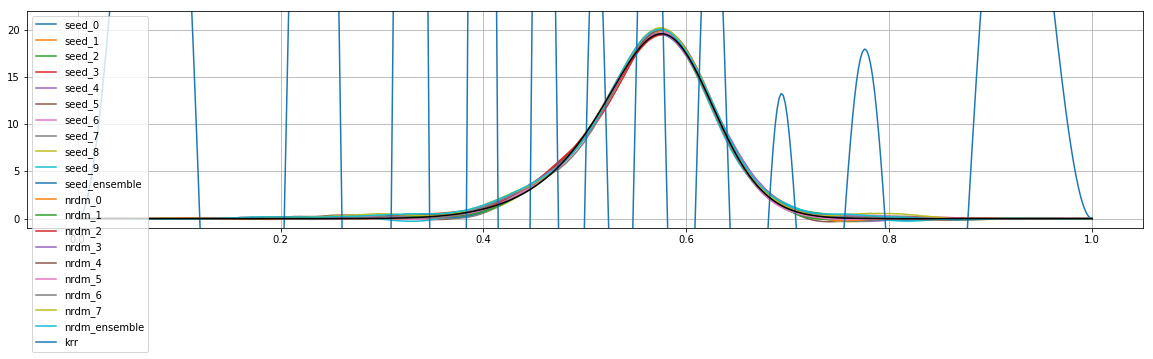

In [9]:
ke, derivative = ModelTest(models.values()).predict(np.repeat(dataset_sample.densities[np.newaxis, :, :], len(models), axis=0))

plt.figure(figsize=(20, 4))
for deriv in derivative: plt.plot(x, deriv[0])
plt.plot(x, dataset_sample.derivatives[0], 'k')
plt.ylim([-1, 22])
plt.grid()
plt.legend(list(models.keys()))
plt.show()

In [0]:
model = models['lucky_proj']

density = dataset_sample.densities#normalize(np.sin(x[np.newaxis, :]*np.pi)**2, h, axis=1)

ke, derivative = model.predict(density)
fderivative = dataset_sample.potentials[0] + derivative
fderivative_proj = model.project(fderivative, density)

plt.figure(figsize=(20, 4))
plt.plot(x, fderivative[0])
plt.plot(x, fderivative_proj[0])
plt.plot(x, dataset_sample.potentials[0] + dataset_sample.derivatives[0], 'k')
plt.grid()
plt.legend(['derivative', 'derivative_proj', 'actual'])
plt.ylim([-2, 2])
plt.show()

In [0]:
ke, derivative = ModelTest(models.values()).predict(np.repeat(dataset_sample.densities[np.newaxis, :, :], len(models), axis=0))
fderivative = np.repeat(dataset_sample.potentials[np.newaxis, :, :], len(models), axis=0) + derivative
fderivative = ModelTest(models.values()).project(fderivative, np.repeat(dataset_sample.densities[np.newaxis, :, :], len(models), axis=0))

plt.figure(figsize=(20, 4))
for fderiv in fderivative: plt.plot(x, fderiv[0])
plt.plot(x, dataset_sample.potentials[0] + dataset_sample.derivatives[0], 'k')
plt.grid()
plt.legend(list(models.keys()))
plt.show()

# Search Self-Consistent Densities

In [10]:
import ipywidgets as widgets
from IPython.display import Audio, HTML, display, clear_output

progress = widgets.IntProgress(value=0, max=0, description='Testing:', 
                               bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

IntProgress(value=0, bar_style='info', description='Testing:', layout=Layout(width='92%'), max=0)

In [11]:
iterations = 5000
epsilon = 0.005

model = models['seed_ensemble']
dataset = dataset_test
M = dataset.densities.shape[0]

density = np.repeat(normalize(np.sin(x[np.newaxis, :]*np.pi)**2, h, axis=1), M, axis=0)
potential = dataset.potentials[:M]

values = model.search(density, potential, iterations, epsilon, progress=progress)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
../q

MAE: [nan]
AE_std: [nan]
AE_max: [nan]


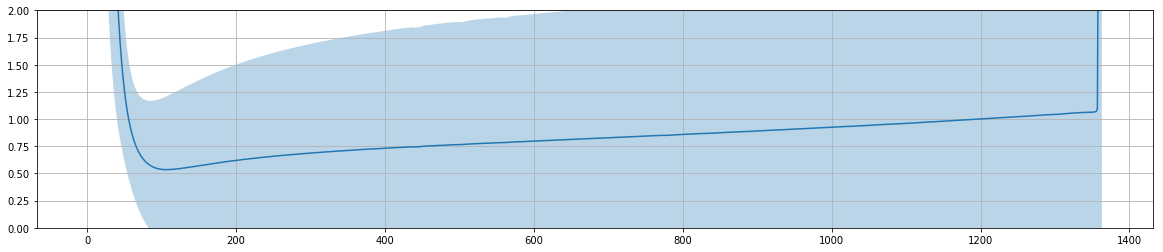

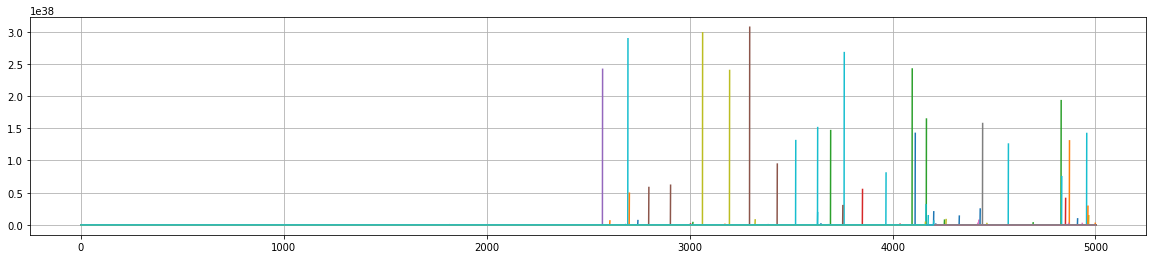

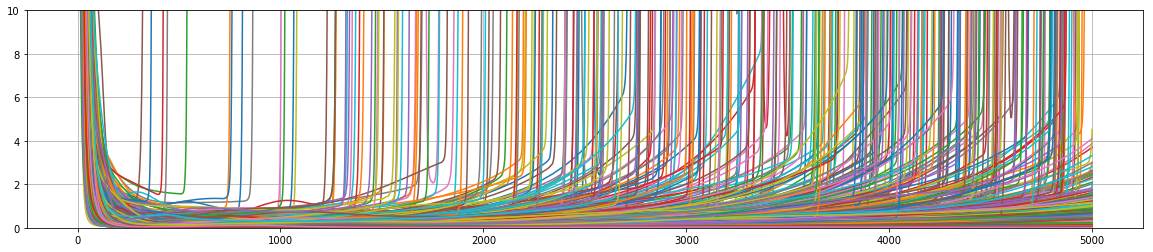

In [12]:
kcalmol_per_hartree = 627.51

if len(values['total_energy'].shape) == 2:
    values['total_energy'] = values['total_energy'][:, :, np.newaxis]

energies_err = np.abs(values['total_energy'] - np.sum(dataset.energies[:M, :N], axis=-1)[np.newaxis, :, np.newaxis])*kcalmol_per_hartree

MAE = np.mean(energies_err, axis=1)
AE_std = np.std(energies_err, axis=1)
AE_max = np.max(energies_err, axis=1)

print('MAE:', MAE[-1])
print('AE_std:', AE_std[-1])
print('AE_max:', AE_max[-1])

plt.figure(figsize=(20, 4))
for y_min, y_max in zip((MAE-AE_std).transpose(), (MAE+AE_std).transpose()): plt.fill_between(values['step'], y_min, y_max, alpha=0.3)
plt.plot(values['step'], MAE)
plt.grid(True)
plt.ylim([0, 2])
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(values['step'], values['loss'])
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(values['step'], values['variance'])
plt.grid(True)
plt.ylim([0, 10])
plt.show()

(5001, 2000)
[3359  448  520 ...  330 4165 4206]
(2000, 1)
MAE: [nan]
AE_std: [nan]
AE_max: [nan]


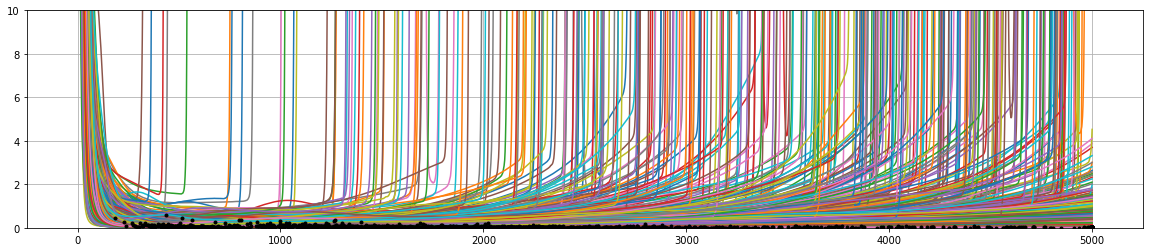

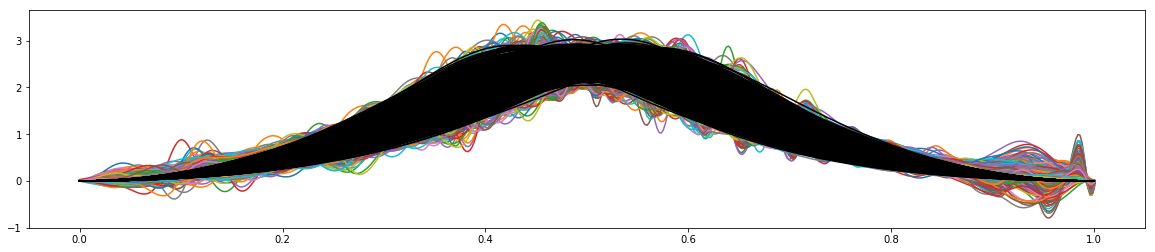

In [13]:
var_kinetic_energy = values['variance']

print(var_kinetic_energy.shape)

lowest_var_index = np.argmin(var_kinetic_energy, axis=0)
print(lowest_var_index)

lowest_var_total_energy = values['total_energy'][lowest_var_index, np.arange(values['total_energy'].shape[1])]
print(lowest_var_total_energy.shape)

energies_err = np.abs(lowest_var_total_energy - np.sum(dataset.energies[:M, :N], axis=-1)[:, np.newaxis])*kcalmol_per_hartree

MAE = np.mean(energies_err, axis=0)
AE_std = np.std(energies_err, axis=0)
AE_max = np.max(energies_err, axis=0)

print('MAE:', MAE)
print('AE_std:', AE_std)
print('AE_max:', AE_max)

plt.figure(figsize=(20, 4))
plt.plot(values['step'], values['variance'])
plt.plot(values['step'][lowest_var_index], values['variance'][lowest_var_index, np.arange(values['variance'].shape[1])], '.k')
plt.grid(True)
plt.ylim([0, 10])
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(x, model.lowest_var_density.transpose())
plt.plot(x, dataset.densities[:M, :].transpose(), 'k')
plt.show()

In [0]:
kcalmol_per_hartree = 627.51

if len(total_energies_.shape) == 2:
    total_energies_ = total_energies_[:, :, np.newaxis]

energies_err = np.abs(total_energies_ - np.sum(dataset.energies[:M, :N], axis=-1)[np.newaxis, :, np.newaxis])*kcalmol_per_hartree

MAE = np.mean(energies_err, axis=1)
AE_std = np.std(energies_err, axis=1)
AE_max = np.max(energies_err, axis=1)

print('MAE:', MAE[var_min])
print('AE_std:', AE_std[var_min])
print('AE_max:', AE_max[var_min])

if len(densities_.shape) == 3:
    densities_ = densities_[:, :, :, np.newaxis]
    functional_derivatives_ = functional_derivatives_[:, :, :, np.newaxis]

for densities in np.moveaxis(densities_, 3, 0):
    print(np.array(densities).shape)
    plt.figure(figsize=(20, 4))
    plt.plot(x, densities[var_min, :, :].transpose())
    plt.plot(x, dataset.densities[:M, :].transpose(), 'k')
    plt.legend(legend)
    plt.show()


In [0]:
for total_energies, title in zip(values['total_energy'].transpose(), legend):
    plt.figure(figsize=(20, 4))
    #plt.plot(steps_, kinetic_energies_)
    plt.plot(values['step'], total_energies.transpose())
    plt.plot(values['step'][-1], np.sum(dataset.energies[:M, :N], axis=-1)[np.newaxis, :], 'k.')
    #plt.plot(steps_, potential_energies_)
    plt.ylim([min(dataset.energies[:M, :N])-2, max(dataset.energies[:M, :N])+2])
    plt.grid(True)
    plt.title(title)
    plt.show()

In [0]:
if len(values['density'].shape) == 3:
    values['density'] = values['density'][:, :, :, np.newaxis]
    values['functional_derivative'] = values['functional_derivative'][:, :, :, np.newaxis]

for densities in np.moveaxis(values['density'], 3, 0):
    plt.figure(figsize=(20, 4))
    plt.plot(x, densities[-1, :, :].transpose())
    plt.plot(x, dataset.densities[:M, :].transpose(), 'k')
    plt.show()

In [0]:
for densities in np.moveaxis(values['density'], 3, 0):
    anim_plot(np.moveaxis(densities, 1, 2), x, interval=10, bar='Animation')

In [0]:
for functional_derivatives in np.moveaxis(values['functional_derivative'], 3, 0):
    anim_plot(np.moveaxis(functional_derivatives, 1, 2), x, interval=10, bar='Animation')

# Hyperparameter Search

In [14]:
dataset = InputPipeline(N=N, dataset_file=os.path.join(data_dir, 'recreate', 'dataset_validation.pkl'))
M = dataset.densities.shape[0]
iterations = 5000
epsilon = 0.005

import ipywidgets as widgets
from IPython.display import Audio, HTML, display, clear_output

progress = widgets.IntProgress(value=0, max=0, description='Training:', 
                               bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

alphas = np.concatenate([np.zeros(shape=(1,)), np.logspace(np.log10(100), np.log10(10000), 5)])
print(alphas)

IntProgress(value=0, bar_style='info', description='Training:', layout=Layout(width='92%'), max=0)

[    0.           100.           316.22776602  1000.
  3162.27766017 10000.        ]


In [0]:
values_n = []
models_n = []

for alpha in alphas:
    print(alpha)
    
    model = ModelEnsemble([models['seed_0'], 
                           models['seed_1'], 
                           models['seed_2'], 
                           models['seed_3'],
                           models['seed_4'], 
                           models['seed_5'], 
                           models['seed_6'], 
                           models['seed_7'],
                           models['seed_8'], 
                           models['seed_9']], alpha=alpha)


    density = np.repeat(normalize(np.sin(x[np.newaxis, :]*np.pi)**2, h, axis=1), M, axis=0)
    potential = dataset.potentials[:M]

    values = model.search(density, potential, iterations, epsilon)#, progress=progress)
    values_n.append(values)
    models_n.append(model)
    
    #import pickle
    #with open('../data/minvar_' + str(alpha) + '.pkl', 'wb') as f:
    #    pickle.dump(values, f)

0.0
100.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

316.22776601683796
1000.0


../quantumflow/calculus_utils.py:8: RuntimeWarning: invalid value encountered in add
  return h * (np.sum(data, axis=axis) - 0.5 * (np.take(data, 0, axis=axis) + np.take(data, -1, axis=axis)))


3162.2776601683795
10000.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in multiply


In [0]:
values_n = []
not_found = []

import pickle
for alpha in alphas:
    try:
        with open('../data/minvar_' + str(alpha) + '.pkl', 'rb') as f:
            values_n.append(pickle.load(f))
    except FileNotFoundError:
        not_found.append(alpha)
not_found

[0.0, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0]

In [0]:
alphas = [alpha for alpha in alphas]

In [0]:
kcalmol_per_hartree = 627.51

final_mae = []

for values in values_n:
    kenergies_err = np.abs(values['total_energy'][:, :, np.newaxis] - np.sum(dataset.energies[:M, :N], axis=-1)[np.newaxis, :, np.newaxis])*kcalmol_per_hartree
    MAE = np.nanmean(kenergies_err, axis=1)
    final_mae.append(MAE[-1])

min_final_mae_index = np.nanargmin(final_mae)
min_final_mae_alpha = alphas[min_final_mae_index]
print('minimum: ', final_mae[min_final_mae_index][0])

f, (a0, a1) = plt.subplots(1, 2, figsize=(10, 2), dpi=100, gridspec_kw={'width_ratios': [1, 20]})
a0.plot([0], final_mae[0], '.')
a0.set_xticks([0])
#a0.set_ylim([0, 3])
a0.set_ylabel('mean absolute error')
a1.plot(alphas, final_mae)
a1.plot(min_final_mae_alpha, final_mae[min_final_mae_index], '.k')
a1.set_xscale('log')
a1.set_ylim([0, 30])
a1.set_xlabel('alpha')
a1.grid(True)
f.tight_layout()
plt.legend(['minimum: {:.02f}'.format(final_mae[min_final_mae_index][0]), 
            'at alpha={:.02f}'.format(min_final_mae_alpha)])
plt.show()

NameError: ignored

minimum:  0.6288146518162698


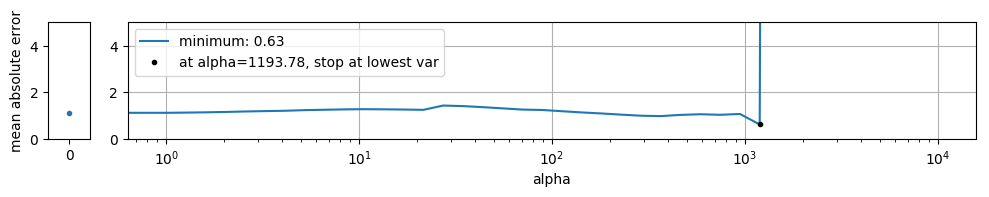

In [0]:
kcalmol_per_hartree = 627.51

lowest_var_mae = []
for values in values_n:
    
    var_kinetic_energy = values['variance']
    lowest_var_index = np.nanargmin(var_kinetic_energy, axis=0)
    lowest_var_total_energy = values['total_energy'][lowest_var_index, np.arange(values['total_energy'].shape[1])]

    energies_err = np.abs(lowest_var_total_energy - np.sum(dataset.energies[:M, :N], axis=-1))*kcalmol_per_hartree

    MAE = np.mean(energies_err, axis=0)
    lowest_var_mae.append(MAE)

    
min_lowest_var_mae_index = np.argmin(lowest_var_mae)
min_lowest_var_mae_alpha = alphas[min_lowest_var_mae_index]
print('minimum: ', lowest_var_mae[min_lowest_var_mae_index])

f, (a0, a1) = plt.subplots(1, 2, figsize=(10, 2), dpi=100, gridspec_kw={'width_ratios': [1, 20]})
a0.plot([0], lowest_var_mae[0], '.')
a0.set_xticks([0])
a0.set_ylim([0, 5])
a0.set_ylabel('mean absolute error')
a1.plot(alphas, lowest_var_mae)
a1.plot(min_lowest_var_mae_alpha, lowest_var_mae[min_lowest_var_mae_index], '.k')
a1.set_xscale('log')
a1.set_ylim([0, 5])
a1.set_xlabel('alpha')
a1.grid(True)
plt.legend(['minimum: {:.02f}'.format(lowest_var_mae[min_lowest_var_mae_index]), 
            'at alpha={:.02f}, stop at lowest var'.format(min_lowest_var_mae_alpha)])
f.tight_layout()
plt.show()

In [0]:
kcalmol_per_hartree = 627.51

early_mae = []
early_index = []

for values in values_n:
    kenergies_err = np.abs(values['total_energy'][:, :, np.newaxis] - np.sum(dataset.energies[:M, :N], axis=-1)[np.newaxis, :, np.newaxis])*kcalmol_per_hartree

    MAE = np.mean(kenergies_err, axis=1)
    lowest_mae_index = np.argmin(MAE)
    early_mae.append(MAE[lowest_mae_index])
    early_index.append(lowest_mae_index)
    
min_early_mae_index = np.argmin(early_mae)
min_early_mae_alpha = alphas[min_early_mae_index]
print('minimum: ', early_mae[min_early_mae_index][0])

f, (a0, a1) = plt.subplots(1, 2, figsize=(10, 2), dpi=200, gridspec_kw={'width_ratios': [1, 20]})
a0.plot([0], early_mae[0], '.')
a0.set_xticks([0])
a0.set_ylim([0, 3])
a0.set_ylabel('mean absolute error')
a1.plot(alphas, early_mae)
a1.plot(min_early_mae_alpha, early_mae[min_early_mae_index], '.k')
a1.set_xscale('log')
a1.set_ylim([0, 3])
a1.set_xlabel('alpha')
a1.grid(True)
plt.legend(['minimum: {:.02f}'.format(early_mae[min_early_mae_index][0]), 
            'at alpha={:.02f}, stop at step={}'.format(min_early_mae_alpha, early_index[min_early_mae_index])])
f.tight_layout()
plt.show()

f, (a0, a1) = plt.subplots(1, 2, figsize=(10, 2), dpi=200, gridspec_kw={'width_ratios': [1, 20]})
a0.plot([0], early_index[0], '.')
a0.set_xticks([0])
a0.set_ylim([0, 100])
a0.set_ylabel('mean absolute error')
a1.plot(alphas, early_index)
a1.set_xscale('log')
a1.set_xlabel('alpha')
a1.set_ylim([0, 100])
a1.grid(True)
f.tight_layout()
plt.show()

In [0]:
disp = 6
hparams_method = 'final'

if hparams_method == 'final':
    values = values_n[min_final_mae_index]
    index = -1
elif hparams_method == 'early':
    values = values_n[min_early_mae_index]
    index = early_index[min_early_mae_index]
elif hparams_method == 'lowest_var':
    values = values_n[min_lowest_var_mae_index]
    index = lowest_index[min_lowest_var_mae_index]

In [0]:
for densities in np.moveaxis(values['density'][:, :, :, np.newaxis] if len(values['density'].shape) == 3 \
                             else values['density'], 3, 0):
    plt.figure(figsize=(20, 4))
    plt.plot(x, densities[index, :disp, :].transpose())
    plt.plot(x, dataset.densities[:disp, :].transpose(), 'k')
    plt.show()

In [0]:
for densities in np.moveaxis(values['density'][:, :, :, np.newaxis] if len(values['density'].shape) == 3 \
                             else values['density'], 3, 0):
    anim_plot(np.moveaxis(densities[:index, :disp, :], 1, 2), x, interval=10, bar='Animation')